In [7]:
import numpy as np
from skimage.draw import circle, polygon

from batchflow import ImagesBatch, action, Dataset, inbatch_parallel, any_action_failed
from src import show_samples

In [8]:
def creating_images(size, r_min, r_max):
    img = np.zeros((size, size, 2))
    loc = []
    vals = [255, 255]
    for f,v in zip(['c', 's'], vals):
        r = np.random.randint(r_min, r_max + 1)
        xc, yc = np.random.randint(r, size - r + 1, 2)
        if f == "c":
             mask = circle(xc, yc, r, (size, size))
        if f == "s":
             mask = polygon((xc - r, xc + r, xc + r, xc - r),
                            (yc - r, yc - r, yc + r, yc + r), (size, size))
        img[:, :, ["c", "s"].index(f)][mask] = v
        loc.append([xc, yc, r])
    return img, np.array(loc)

In [9]:
class ShapesBatch(ImagesBatch):
    @action
    @inbatch_parallel(init="indices", post="_assemble_batch")
    def creating_images(self, i, size, r_min=5, r_max=None):
        """Generate images with geometrical shapes.
        """
        if r_max is None:
            r_max = size // 2
        return creating_images(size, r_min, r_max)
    
    def _assemble_batch(self, results, *args, **kwargs):
        """Concatenate results of different workers.
        """
        _ = args, kwargs
        img, loc = list(zip(*results))
        img = np.stack(img)
        loc = np.stack(loc)
        self.images = np.clip(img.sum(axis=-1, keepdims=True), 0, 255)
        self.labels = loc[:, 0, :2]
        self.masks = np.clip(img[:, :, :, :1], 0, 1).astype(int)
        return self

In [10]:
Images = Dataset(10000, ShapesBatch)

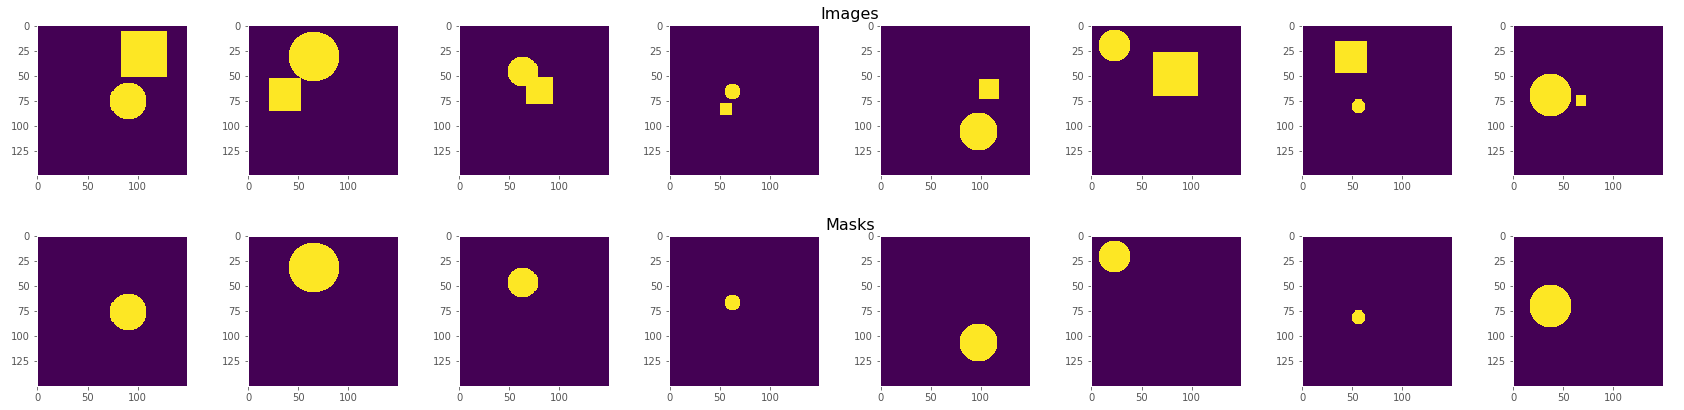

In [11]:
size = 8
batch = Images.next_batch(size).creating_images(150, r_max=25)

show_samples([batch.images[:, :, :, 0], batch.masks[:, :, :, 0]], row_titles=["Images", "Masks"])